# Kaggle Toxic Comments Challenge

In [1]:
import pandas as pd
import numpy as np
import gensim
import keras
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

c:\users\symphonyai\anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
%matplotlib inline

## Data Loading

In [5]:
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [6]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,age_category
0,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0,18-30
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,30-45
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,18-30
3,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0,30-45
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,30-45


In [7]:
df_test.isnull().sum()

id              0
comment_text    0
dtype: int64

In [10]:
df.age_category.value_counts()/len(df)*100

18-30       53.999160
30-45       34.724981
45-60        8.242099
Under 18     2.199021
Over 60      0.834738
Name: age_category, dtype: float64

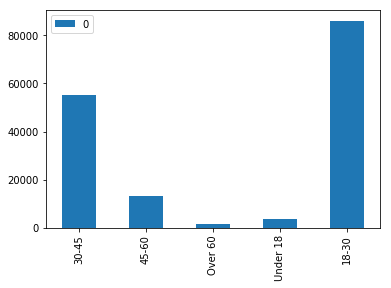

In [11]:
from collections import Counter
age_categories_list = list(df.age_category.values)
age_counts = Counter(age_categories_list)
age_plot_df = pd.DataFrame.from_dict(age_counts, orient='index')
age_plot_df.plot(kind='bar')

In [12]:
df.drop(['age_category'], axis = 1, inplace = True)

## Text Preprocessing

In [14]:
simple_tokens = df.comment_text.apply(gensim.utils.simple_preprocess)

In [18]:
phrases = gensim.models.phrases.Phrases(simple_tokens)
tokenizer = gensim.models.phrases.Phraser(phrases)

In [19]:
tokenized_text = list(tokenizer[simple_tokens]) # a 2D list of all the keywords from comment_text

In [21]:
corpus_dict = gensim.corpora.dictionary.Dictionary(tokenized_text)

In [22]:
TARGET_CLASSES = df.columns[1:]

In [23]:
TARGET_CLASSES

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [24]:
targets = df[TARGET_CLASSES].values

## Exploratory Data Analysis

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

(0, 400)

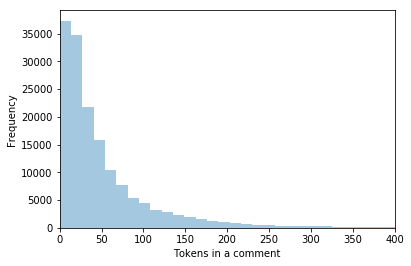

In [26]:
sns.distplot([len(doc) for doc in tokenized_text], bins=100, kde=False, label='Number of tokens per comment.')
plt.xlabel("Tokens in a comment")
plt.ylabel("Frequency")
plt.xlim((0, 400))

## Training word2vec model

In [27]:
word2vec = gensim.models.word2vec.Word2Vec(tokenized_text, window=5, size=100, min_count=2, workers=6)

In [30]:
features = np.zeros((len(tokenized_text), word2vec.vector_size))
for i, tokens in enumerate(tokenized_text):
    tokens = [t for t in tokens if t in word2vec.wv.vocab]
    if tokens:
        features[i, :] = np.mean([word2vec.wv[t] / word2vec.wv.vocab[t].count for t in tokens], axis=0)

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(word2vec.vector_size,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(features, targets, epochs=10, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/10


In [39]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model-baseline.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
# serialize model to JSON
model_json = model.to_json()
with open("model-baseline.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model-baseline.h5")
print("Saved model to disk")

Saved model to disk


## Sequential models

In [40]:
# Note: shifting indices by 1 as index 0 will be used for padding.
docs = [[idx + 1 for idx in corpus_dict.doc2idx(doc)]  for doc in tokenized_text]

In [41]:
MAX_SEQ_LEN = 50
padded_docs = keras.preprocessing.sequence.pad_sequences(docs, maxlen=MAX_SEQ_LEN, truncating='post', value=0)

In [42]:
max_idx = max(c for d in docs for c in d)
max_idx

136735

In [43]:
embeddings = np.array([np.random.normal(size=word2vec.vector_size)]+ # for the '0' padding word
                      [word2vec.wv[corpus_dict[idx]]
                      if corpus_dict[idx] in word2vec.wv.vocab
                      else np.random.normal(size=word2vec.vector_size)
                      for idx in range(max_idx)])

### CNN Model

In [45]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPool1D, Flatten, BatchNormalization

model = Sequential()
model.add(Embedding(max_idx + 1, word2vec.vector_size, input_length=MAX_SEQ_LEN))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(52, 5, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(128, 3, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Flatten())
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid',
                kernel_regularizer=keras.regularizers.l2(0.02)))
model.compile(Adam(0.001), 'binary_crossentropy')

In [46]:
model.fit(padded_docs, targets, batch_size=512, epochs=20, validation_split=0.1)

Train on 86265 samples, validate on 9586 samples
Epoch 1/20
86265/86265 [==============================] - 133s - loss: 0.5653 - val_loss: 0.3098

In [48]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model-cnn.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
# serialize model to JSON
model_json = model.to_json()
with open("model-cnn.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model-cnn.h5")
print("Saved model to disk")

Saved model to disk


## Submission

In [47]:
def comment_to_sequential_input(comment):
    tokens = tokenizer[gensim.utils.simple_preprocess(comment)]
    t_ids = [corpus_dict.token2id[t] + 1 for t in tokens if t in word2vec.wv.vocab and t in corpus_dict.token2id]
    return keras.preprocessing.sequence.pad_sequences([t_ids], maxlen=MAX_SEQ_LEN)[0]

In [49]:
test_input = [comment_to_sequential_input("You are a jerk you freakin indian.").reshape(1, -1)]
for target_class, score in zip(TARGET_CLASSES, model.predict(test_input)[0]):
    print("{}: {:.2f}%".format(target_class, score * 100))

toxic: 99.93%
severe_toxic: 9.97%
obscene: 89.96%
threat: 2.02%
insult: 82.76%
identity_hate: 9.46%


In [50]:
test_inputs = np.array([comment_to_sequential_input(doc) for doc in df_test.comment_text])

In [51]:
test_outputs = model.predict(test_inputs)

In [52]:
test_outputs[0]

array([ 0.0789036 ,  0.00617168,  0.01881345,  0.00449502,  0.02149433,
        0.00881813], dtype=float32)

In [53]:
output_df = df_test.reset_index()[['id']].copy()

In [54]:
for i, target_class in enumerate(TARGET_CLASSES):
    output_df[target_class] = test_outputs[:, i]

In [55]:
output_df[output_df.toxic > 0.5].sample(10, random_state=0).merge(df_test.reset_index(), on='id')

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,970795210363,0.997292,0.020285,0.811091,0.006286,0.588454,0.021558,first things first. you're a fucking weirdo vi...
1,160445573936,0.680250,0.005177,0.104825,0.002904,0.059663,0.004923,:Nice try. When are you going to provide any p...
2,351832393175,0.536854,0.014038,0.116943,0.006331,0.093422,0.010558,"""\nI have a low IQ, because I come from Easter..."
3,654215902316,0.635371,0.011294,0.098857,0.004592,0.074091,0.011511,Justin garcia \n\njustin is a awsome kid that ...
4,238771191154,0.886325,0.026841,0.233254,0.013289,0.252669,0.040706,wow dude... you're a real douche. wow.
5,486825599278,0.995695,0.048299,0.753739,0.009197,0.565907,0.037099,This is bullshit. I hate you all. 128.61.128.159
6,895629235610,0.928848,0.020815,0.284615,0.006741,0.209101,0.014945,Please stop raping little boys in the anus. Do...
7,45365949607,0.993167,0.052128,0.728390,0.013292,0.619307,0.058687,why? ==\nare you such a stupid bitch?\n\n==
8,654103653477,0.986770,0.039801,0.530670,0.012741,0.445994,0.036060,So what? Go away and stop harassing me. You're...
9,439043725463,0.989504,0.012254,0.314106,0.007367,0.521264,0.008229,"Bonjou,\nMwen administratè nan wikipedya ak wi..."


In [57]:
output_df.to_csv('cnn-pred.csv', index=False)